<a href="https://colab.research.google.com/github/demegire/ukeba/blob/main/optimization_metric_calculation_and_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Functions to obtain:
*   B-t (pareto) and B-p graphs

for a given set of parameters, and 
*   Optimal budget allocation
*   Reach
*   Exposure percentage
*   Estimated return
for two platforms



In [54]:
# imports

import matplotlib.pyplot as plt
from itertools import accumulate
import numpy as np
from scipy.optimize import curve_fit

In [55]:
## effectiveness function estimation stuff / popt pcov initialization

ad_spend_android = [0.74, 7.42, 17.15, 15.93, 8.76]
reach_android = [1756, 80048, 112928, 119233, 56481]

ad_spend_ios = [9.4, 24.9, 15.7]
reach_ios = [54976, 84417, 44865]

cum_ad_spend_android = list(accumulate(ad_spend_android))
cum_reach_android = list(accumulate(reach_android))

def func(x, m, u):
  return m * (1 - np.exp(-1 * u * x))

ad_spend_android = np.array(ad_spend_android)
cum_ad_spend_android = np.array(cum_ad_spend_android)
cum_reach_android = np.array(cum_reach_android)

popt, pcov = curve_fit(func, cum_ad_spend_android, cum_reach_android)

In [56]:
# parameter initialization - will be taken as input

disc = 200 # discritization parameter

u = popt[0]

p1 = 0.75
a1 = 0.1
ms1 = 0.19
T1 = 10
n1 = 4000
ltv1 = 19.28

p2 = 0.75
a2 = 2  
ms2 = 0.25
T2 = 10
n2 = 2500
ltv2 = 6.06

In [57]:
# B lists calculator

# b1_a = B values per p
# b1_array = b1_a in column 0, ltv*n*p in column 1
# b_par = B values per t (for regular pareto)

def b_calc(p, a, ms, T, ltv, n, disc):
        b1_a = [pareto_frontier(p,a,ms,T) for p in np.linspace(0,1,disc)]
        b1_array = np.column_stack((b1_a, ltv*n*np.linspace(0,1,disc)))  
        b_par = [pareto_frontier(p,a,ms,t) for t in np.arange(0, T, 0.1)]
        return b1_a, b1_array, b_par

In [58]:
# optimization model

def maximize_p1p2_sum(b1_array, b2_array, a1, ms1, T1, a2, ms2, T2, b_limit):
        max_sum = -1
        optimal_p1 = -1
        optimal_p2 = -1
        opt_b1 = -1
        opt_b2 = -1
        for b1 in range(len(b1_array)):
            for b2 in range(len(b2_array)):
              if (b1_array[b1][0]+b2_array[b2][0])<b_limit:
                p1 = b1_array[b1][1]
                p2 = b2_array[b2][1]
                current_sum = p1 + p2
                if current_sum > max_sum:
                    max_sum = current_sum
                    optimal_p1 = p1
                    optimal_p2 = p2
                    opt_b1 = b1_array[b1][0]
                    opt_b2 = b2_array[b2][0]
        return optimal_p1, optimal_p2, opt_b1, opt_b2, max_sum

In [59]:
## updated pareto

def pareto_frontier_B_b(p, a, m, u, T):
        tmin = np.log((a * p + 1) / (1 - p)) / (m * (1 + a))
        B = ((-T/u) * np.log(1 - (tmin/T)))

        beta = u * (m - 1/((1 + a) * T) * np.log((a * p + 1)/((1 - p))))
        bid = 1 / u * np.log(m * u / beta)

        return B, bid

In [60]:
## old pareto

def pareto_frontier(p, a, ms, T):
        tmin = np.log((a * p + 1) / (1 - p)) / (ms * (1 + a))
        B = 100000000*((-T/popt[0]) * np.log(1 - (tmin/T)))
        return B

In [61]:
# pareto chart plotter

def pareto_plotter(b_par, T):
        plt.plot(np.arange(0, T, 0.1), b_par)
        plt.title("Pareto Frontier, B (y) vs T (x) ") 
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        return 0

In [62]:
# B vs p for a given T plotter

def b_vs_p_plotter(b1_a, T):
        plt.plot(np.linspace(0,1,200), b1_a)
        plt.title("Pareto Frontier, B (y) vs p (x) for T={}".format(T))  
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        return 0

Example run

In [63]:
arr1, arr1_opt, par1 = b_calc(p1, a1, ms1, T1, ltv1, n1, 200)
arr2, arr2_opt, par2 = b_calc(p2, a2, ms2, T2, ltv2, n2, 200)

<ipython-input-60-93192b17f4b4>:5: RuntimeWarning: invalid value encountered in log
  B = 100000000*((-T/popt[0]) * np.log(1 - (tmin/T)))
<ipython-input-60-93192b17f4b4>:4: RuntimeWarning: divide by zero encountered in double_scalars
  tmin = np.log((a * p + 1) / (1 - p)) / (ms * (1 + a))
<ipython-input-60-93192b17f4b4>:5: RuntimeWarning: divide by zero encountered in double_scalars
  B = 100000000*((-T/popt[0]) * np.log(1 - (tmin/T)))


0

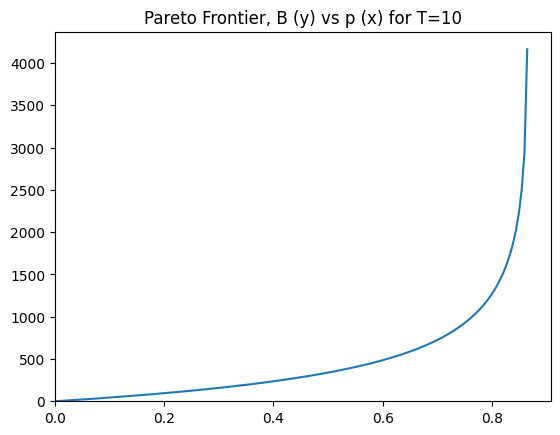

In [64]:
b_vs_p_plotter(arr1, T1)

0

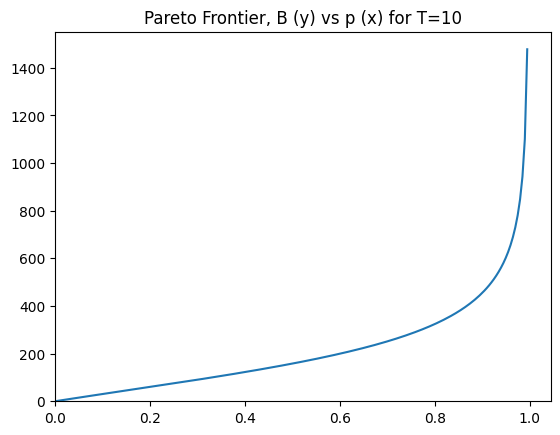

In [65]:
b_vs_p_plotter(arr2, T2)

0

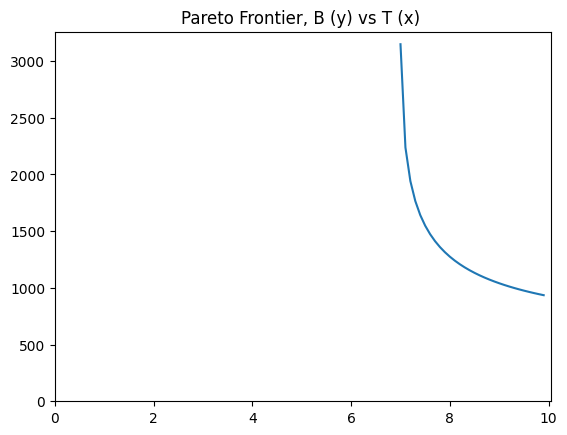

In [66]:
pareto_plotter(par1, T1)

0

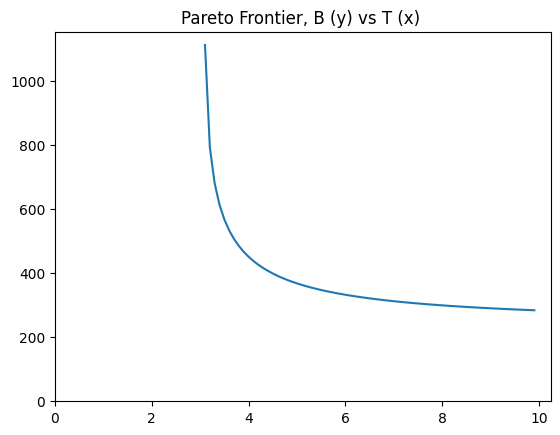

In [67]:
pareto_plotter(par2, T2)

In [68]:
return1, return2, allocb1, allocb2, total_return = maximize_p1p2_sum(arr1_opt, arr2_opt, a1, ms1, T1, a2, ms2, T2, 1000)

In [69]:
reach1 = return1 / ltv1
reach2 = return2 / ltv2
exp1 = reach1 / n1
exp2 = reach2 / n2

print("================================================================")
print("\n platform 1 metrics")
print("estimated return from platform 1: %.2f" % return1)
print("allocated budget for platform 1: %.2f" % allocb1)
print("# of people reached from platform 1: %i" % reach1)
print("exposure percentage of target audicence for platform 1: %.2f" % exp1)
print("\n platform 2 metrics")
print("estimated return from platform 2: %.2f" % return2)
print("allocated budget for platform 2: %i" % allocb2)
print("# of people reached from platform 2: %.2f" % reach2)
print("exposure percentage of target audicence for platform 2: %.2f" % exp2)
print("\n total metrics")
print("total estimated return: %i" % total_return)
print("================================================================")



 platform 1 metrics
estimated return from platform 1: 54255.28
allocated budget for platform 1: 737.07
# of people reached from platform 1: 2814
exposure percentage of target audicence for platform 1: 0.70

 platform 2 metrics
estimated return from platform 2: 10886.68
allocated budget for platform 2: 262
# of people reached from platform 2: 1796.48
exposure percentage of target audicence for platform 2: 0.72

 total metrics
total estimated return: 65141
